In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns 
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import datetime as dt
import random
import os 
import h5py
from sklearn.preprocessing import StandardScaler

BATCH_SIZE = 128
PATIENCE = 20
MAX_EPOCH = 100
TRAIN_STEPS = 168
PREDICT_STEPS = 24
WINDOW_SIZE = TRAIN_STEPS + PREDICT_STEPS 



In [2]:
FILE_DIR = 'C:\\Users\\Zain Ahmed\\Desktop\\Literature review\\Project Folder\\Data.xlsx'


# Loading the data from execl file

In [3]:
data = pd.read_excel(FILE_DIR)
data['Time']=data['Time'].astype(int)-1
data = data.loc[:,('DATE','Time',' Load(KW)   ','Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','Stn Press (kPa)')]
data['datetime'] = data['DATE'].astype('str') + '-' + data['Time'].astype('str')
data['datetime']=pd.to_datetime(data['datetime'],format='%Y-%m-%d-%H')
#data['is_weekday'] = (data['datetime'].dt.weekday<=5).astype('int')
#data['month'] = (data['datetime']).dt.month
data = data.set_index('datetime')
data = data.drop(columns=['DATE','Time'])
#data['datetime']=pd.to_datetime(data['datetime'],format='%Y-%m-%d-%H')


# Keeping DATE,Time and Load Columns Only 
# Also keeping daily hours between 0-23

In [4]:
#data = data.loc[:,('DATE','Time',' Load(KW)   ')]
#DROPPING WIND CHILL DUE TO HIGH NANs
#data = data.loc[:,('DATE','Time',' Load(KW)   ','Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','Stn Press (kPa)')]

# Concatenate Date and Time

In [5]:
#data['datetime'] = data['DATE'].astype('str') + '-' + data['Time'].astype('str')

In [6]:
#data['datetime']=pd.to_datetime(data['datetime'],format='%Y-%m-%d-%H')

In [7]:
#data = data.set_index('datetime')

In [8]:
#data = data.drop(columns=['DATE','Time'])

In [9]:
num_of_bre = (data.asfreq(freq='1H').shape[0]) - (data.shape[0])
percen = ((num_of_bre)/data.shape[0])*100
print('The number of breaks in the data are {} which is {:0.2} percent of the total data'.format(num_of_bre,percen))

The number of breaks in the data are 3 which is 0.0081 percent of the total data


# We will ensure the continuity of the data

In [10]:
#num_of_bre = (data.asfreq(freq='1H').shape[0]) - (data.shape[0])
#percen = ((num_of_bre)/data.shape[0])*100
#print('The number of breaks in the data are {} which is {:0.2} percent of the total data'.format(num_of_bre,percen))

# Make the data continous 

In [11]:
data = data.asfreq(freq='1H')

In [12]:
#data = data.asfreq(freq='1H')

<AxesSubplot:xlabel='datetime'>

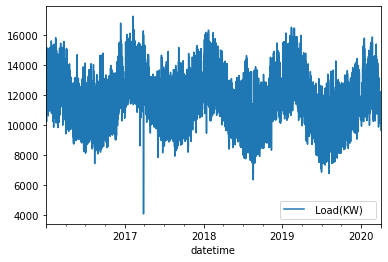

In [13]:
data.plot(y=' Load(KW)   ')

In [14]:
data.shape

(37224, 8)

# We will divide our data in train, validation and test sets 

In [15]:
tr_id = int((data.shape[0]*0.75)/24)*24
val_id = int((data.shape[0]*0.90)/24)*24
tra_data = data.iloc[:tr_id,:]
val_data = data.iloc[tr_id:val_id,:]
tes_data = data.iloc[val_id:,:]

In [16]:
tr_id

27912

# Now we will write the proprocessing function

In [17]:
def pre_process(sample):
    '''
    Takes a dataframe and 
            
    - replaces NA values by forward filling
    
    '''
    ## Use the below line of code to sample data based on hours 
    ##sample = sample[(sample.index.dayofweek<5) & ((of_da_fi.index.hour>4) & (of_da_fi.index.hour<19))]
    
    #using forward filling method to fill the missing data 
        
    sample = sample.fillna(method='ffill')
    
    ## This line of code checks for NA values 
    
    check_na = int(sample.isnull().sum().sum())
    
    print('There are {} NA values in the dataframe'.format(check_na))
    
    #plt.figure(figsize=(3,3))
    
    #sns.violinplot(data=sample)
    
    #plt.xticks(rotation=90)
        
    return sample

In [18]:
train_data = pre_process(tra_data)


There are 0 NA values in the dataframe


In [19]:
vali_data = pre_process(val_data)


There are 0 NA values in the dataframe


In [20]:
test_data = pre_process(tes_data)

There are 0 NA values in the dataframe


In [21]:
tes_data.fillna(method='ffill').isnull().sum()

 Load(KW)              0
Temp (°C)              0
Dew Point Temp (°C)    0
Rel Hum (%)            0
Wind Dir (10s deg)     0
Wind Spd (km/h)        0
Visibility (km)        0
Stn Press (kPa)        0
dtype: int64

# Rolling window function 

In [22]:
def rolling_window(array_data,input_size,output_size,offset):
    '''
    The function takes a series array_data of size (size,) 

    and generates
    
    a array of size (input_size,((array_size-(input_size+output_size)/stride)+1)) as inputs 
    
    and array of size (array_size-(input_size+output_size)/stride)+1)as output 
    
    '''
        
    # Normalizing the dataset
        
    scaler = StandardScaler()
    
    scaler = scaler.fit(array_data)
    
    array_data = scaler.transform(array_data)
    
#     lab_data = array_data[:,0]
    
#     for i in range(input_size,len(array_data)-output_size+1,offset):
            
#             data.append(array_data[i-input_size:i,0:array_data.shape[1]])
    
#             labels.append(lab_data[i:i+output_size])

        
    data_idx = sliding_window_view(np.arange(array_data.shape[0]).reshape(-1),window_shape=input_size)[::offset][:-1]
    
    data = array_data[data_idx]

    labels = sliding_window_view(array_data[input_size:,0].reshape(-1),window_shape=output_size)[::offset]

    
    assert data.shape[0] == labels.shape[0],"Training rows and labels are unequal"    
    
#    if output_size == offset:
        
#        ra_in = random.randint(0,data.shape[0]-2) 
        
#        a = data[ra_in+1,-offset:]
        
#        b = labels[ra_in]
        
#        np.alltrue(a == b)
    
#    data = np.expand_dims(data,axis=2)
    
#    labels = np.expand_dims(labels,axis=2)
    
#    data = np.array(data)
    
#    labels = np.array(labels)
        
    return data,labels,scaler,array_data

# We will use the rolling window of size 168 and output window of size 24

In [23]:
tra_data_sli,tra_lab,tra_sca,tra_stan = rolling_window(train_data,input_size=TRAIN_STEPS,output_size=24,offset=24)
val_data_sli,val_lab,val_sca,val_stan = rolling_window(vali_data,input_size=TRAIN_STEPS,output_size=24,offset=24)
tes_data_sli,tes_lab,test_scaler,tes_stan = rolling_window(test_data,input_size=TRAIN_STEPS,output_size=24,offset=24)

In [24]:
np.save('tra_data_sli',tra_data_sli)
np.save('val_data_sli',val_data_sli)
np.save('tes_data_sli',tes_data_sli)
np.save('tra_lab',tra_lab)
np.save('val_lab',val_lab)
np.save('tes_lab',tes_lab)

# We will now focus on network architecture Implementation

In [25]:
print("Number of training samples are {}".format(tra_data_sli.shape[0]))
print("Number of validation samples are {}".format(val_data_sli.shape[0]))
print("Number of test samples are {}".format(tes_data_sli.shape[0]))

Number of training samples are 1156
Number of validation samples are 225
Number of test samples are 149


In [26]:
tra_lab.shape

(1156, 24)

In [27]:
tra_data_sli.shape

(1156, 168, 8)

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128,return_sequences=True,input_shape=(tra_data_sli.shape[1],tra_data_sli.shape[2])),
    tf.keras.layers.GRU(128,return_sequences=True),
    tf.keras.layers.GRU(128,return_sequences=False),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dense(units=24)
]
)


In [29]:
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    0.1,
#    decay_steps=1000,
#    decay_rate=0.5)

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

ear_stop = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",mode='min',min_delta=5e-4,patience=20,verbose=1
)

model_chk = tf.keras.callbacks.ModelCheckpoint(
            'best_model_GRU_MultiVariate_Std_Scaler.h5',monitor="val_loss",mode='min',verbose=1,save_best_only=True
)


In [30]:
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=["mean_squared_error"])

In [31]:
history = model.fit(x=tra_data_sli,y=tra_lab, epochs=MAX_EPOCH, batch_size=BATCH_SIZE,validation_data=(val_data_sli, val_lab), verbose=1,callbacks=[model_chk,ear_stop])

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.4235 - mean_squared_error: 0.9654
Epoch 1: val_loss improved from inf to 0.39571, saving model to best_model_GRU_MultiVariate_Std_Scaler.h5
10/10 [==============================] - 25s 1s/step - loss: 0.4235 - mean_squared_error: 0.9654 - val_loss: 0.3957 - val_mean_squared_error: 0.8898
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.3955 - mean_squared_error: 0.8908
Epoch 2: val_loss improved from 0.39571 to 0.36843, saving model to best_model_GRU_MultiVariate_Std_Scaler.h5
10/10 [==============================] - 10s 957ms/step - loss: 0.3955 - mean_squared_error: 0.8908 - val_loss: 0.3684 - val_mean_squared_error: 0.8192
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.3622 - mean_squared_error: 0.8045
Epoch 3: val_loss improved from 0.36843 to 0.33410, saving model to best_model_GRU_MultiVariate_Std_Scaler.h5
10/10 [==============================] - 10s 960ms/step - 

Epoch 24/100
10/10 [==============================] - ETA: 0s - loss: 0.1181 - mean_squared_error: 0.2434
Epoch 24: val_loss improved from 0.14779 to 0.14398, saving model to best_model_GRU_MultiVariate_Std_Scaler.h5
10/10 [==============================] - 15s 1s/step - loss: 0.1181 - mean_squared_error: 0.2434 - val_loss: 0.1440 - val_mean_squared_error: 0.2943
Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 0.1169 - mean_squared_error: 0.2413
Epoch 25: val_loss improved from 0.14398 to 0.14129, saving model to best_model_GRU_MultiVariate_Std_Scaler.h5
10/10 [==============================] - 14s 1s/step - loss: 0.1169 - mean_squared_error: 0.2413 - val_loss: 0.1413 - val_mean_squared_error: 0.2887
Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 0.1158 - mean_squared_error: 0.2389
Epoch 26: val_loss improved from 0.14129 to 0.13989, saving model to best_model_GRU_MultiVariate_Std_Scaler.h5
10/10 [==============================] - 14s 1s/ste

Epoch 48/100
10/10 [==============================] - ETA: 0s - loss: 0.0968 - mean_squared_error: 0.1985
Epoch 48: val_loss did not improve from 0.12082
10/10 [==============================] - 14s 1s/step - loss: 0.0968 - mean_squared_error: 0.1985 - val_loss: 0.1275 - val_mean_squared_error: 0.2604
Epoch 49/100
10/10 [==============================] - ETA: 0s - loss: 0.0961 - mean_squared_error: 0.1971
Epoch 49: val_loss did not improve from 0.12082
10/10 [==============================] - 13s 1s/step - loss: 0.0961 - mean_squared_error: 0.1971 - val_loss: 0.1223 - val_mean_squared_error: 0.2492
Epoch 50/100
10/10 [==============================] - ETA: 0s - loss: 0.0957 - mean_squared_error: 0.1966
Epoch 50: val_loss did not improve from 0.12082
10/10 [==============================] - 13s 1s/step - loss: 0.0957 - mean_squared_error: 0.1966 - val_loss: 0.1228 - val_mean_squared_error: 0.2502
Epoch 51/100
10/10 [==============================] - ETA: 0s - loss: 0.0958 - mean_squared

In [32]:
predict = model.predict(x=tes_data_sli)

5/5 [==============================] - 5s 137ms/step


In [34]:
prediction = test_scaler.inverse_transform(np.repeat(predict.flatten().reshape(-1,1),8,axis=1))
grou_tru = test_scaler.inverse_transform(np.repeat(tes_lab.flatten().reshape(-1,1),8,axis=1))
print("Mean Squared Error is: " + str(mean_squared_error(grou_tru[:,0],prediction[:,0])))
print("Mean Absolute Error is: " + str(mean_absolute_error(grou_tru[:,0],prediction[:,0])))

Mean Squared Error is: 429303.1216250789
Mean Absolute Error is: 504.4902294594169


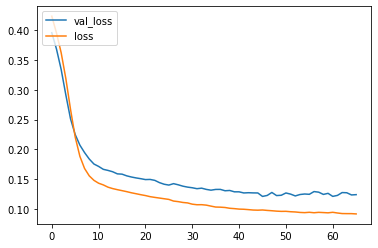

In [35]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['val_loss', 'loss'], loc='upper left')


In [38]:
def plot_compare(pred,label,day):
    label=label[:,0].reshape(-1,24)
    pred=pred[:,0].reshape(-1,24)
    plt.plot(np.arange(24),pred[day],label='GRU')
    plt.plot(np.arange(24),label[day],label='actual')
    plt.xlabel('Hour of Day')
    plt.ylabel('Load (kW)')
    plt.legend()
    plt.plot()

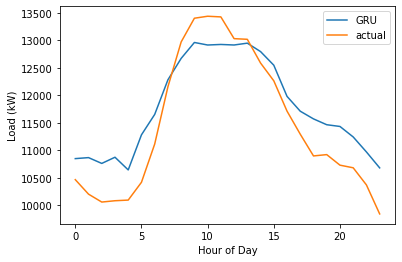

In [39]:
plot_compare(prediction,grou_tru,15)